Note: Dataset saved on my Google Drive, so make sure the 'unsplit.zip' is change the path according to yours.

Dataset contains 6 classes:
1. Organic (O_) / Sampah organik
2. Cardboard / Kardus
3. Glass / Botol kaca
4. Metal / Besi
5. Paper / Kertas
6. Plastic / Botol plastik

# Import libraries

In [ ]:
import numpy as np, pandas as pd, seaborn as sns
import random, os, zipfile, sys, time, re
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.makedirs('garbage')

In [ ]:
!unzip /content/drive/MyDrive/capstone/unsplit.zip -d /content/garbage

# Categorizing data to each classes

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

base_path = "/content/garbage/"

categories = {0: 'O_', 1: 'cardboard', 2: 'glass', 3: 'metal', 4: 'paper', 5: 'plastic'}

In [ ]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  2773


In [ ]:
df.head()

,filename,category
0,cardboard/cardboard259.jpg,1
1,glass/glass193.jpg,2
2,plastic/plastic294.jpg,5
3,plastic/plastic38.jpg,5
4,plastic/plastic414.jpg,5


# Create model

In [ ]:
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False,
                                            input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                                            weights = 'imagenet')

mobilenetv2_layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

In [ ]:
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-tr

In [ ]:
early_stop = EarlyStopping(patience = 2,
                           verbose = 1,
                           monitor='val_categorical_accuracy' ,
                           mode='max',
                           min_delta=0.001,
                           restore_best_weights = True)
callbacks = [early_stop]

call back defined!


# Split data to train, test, val

In [ ]:
df["category"] = df["category"].replace(categories)

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size =', total_train , 'validate size =', total_validate, 'test size =', test_df.shape[0])

train size = 2218 validate size = 388 test size = 167


# Train model

In [ ]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size)

Found 2218 validated image filenames belonging to 6 classes.


In [ ]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 388 validated image filenames belonging to 6 classes.


In [ ]:
EPOCHS = 15
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

Epoch 1/15
34/34 [==============================] - 181s 5s/step - loss: 1.2009 - categorical_accuracy: 0.5474 - val_loss: 0.6378 - val_categorical_accuracy: 0.7734
Epoch 2/15
34/34 [==============================] - 156s 5s/step - loss: 0.6724 - categorical_accuracy: 0.7628 - val_loss: 0.4997 - val_categorical_accuracy: 0.8125
Epoch 3/15
34/34 [==============================] - 153s 4s/step - loss: 0.5613 - categorical_accuracy: 0.7999 - val_loss: 0.4720 - val_categorical_accuracy: 0.8177
Epoch 4/15
34/34 [==============================] - 163s 5s/step - loss: 0.5013 - categorical_accuracy: 0.8245 - val_loss: 0.4202 - val_categorical_accuracy: 0.8464
Epoch 5/15
34/34 [==============================] - 151s 4s/step - loss: 0.4756 - categorical_accuracy: 0.8264 - val_loss: 0.3952 - val_categorical_accuracy: 0.8516
Epoch 6/15
34/34 [==============================] - 155s 5s/step - loss: 0.4564 - categorical_accuracy: 0.8375 - val_loss: 0.3851 - val_categorical_accuracy: 0.8568
Epoch 7/15

# Save model

In [ ]:
model.save("model_7jun_dataunsplit.h5")

# Visualize train and val dataframe loss and accuracy

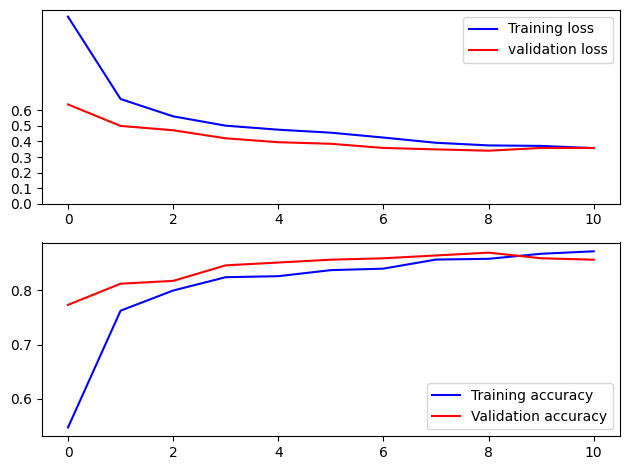

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Evaluate the model

In [ ]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 167 validated image filenames belonging to 6 classes.


In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

<ipython-input-31-f89e32826d0e>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  90.42 % 


In [ ]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'O_', 1: 'cardboard', 2: 'glass', 3: 'metal', 4: 'paper', 5: 'plastic'}


In [ ]:
# get the model's predictions for the test set
preds = model.predict(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

167/167 [==============================] - 8s 45ms/step
              precision    recall  f1-score   support

          O_       1.00      1.00      1.00        28
   cardboard       1.00      0.91      0.95        22
       glass       0.91      0.83      0.87        36
       metal       0.77      0.94      0.85        18
       paper       0.93      0.93      0.93        30
     plastic       0.82      0.85      0.84        33

    accuracy                           0.90       167
   macro avg       0.91      0.91      0.91       167
weighted avg       0.91      0.90      0.91       167



Conclusion: from above shows that accuracy on test set is 90%

# Predicting Trial

In [ ]:
from google.colab import files
import cv2

In [ ]:
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img,(224,224))
    img = np.reshape(img,[1,224,224,3])
    return img

In [ ]:
def predict_image(model, image_path):
    img = load_image(image_path)
    preds = model.predict(img)
    preds = preds.argmax(1)
    preds = [gen_label_map[item] for item in preds]
    plt.imshow(img[0])
    plt.show()
    print(preds)

## Using random sample from dataset

1/1 [==============================] - 1s 1s/step


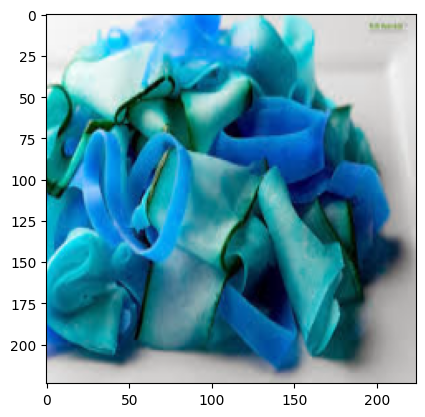

['O_']


In [ ]:
predict_image(model, '/content/garbage/O_/O_13585.jpg')

1/1 [==============================] - 0s 298ms/step


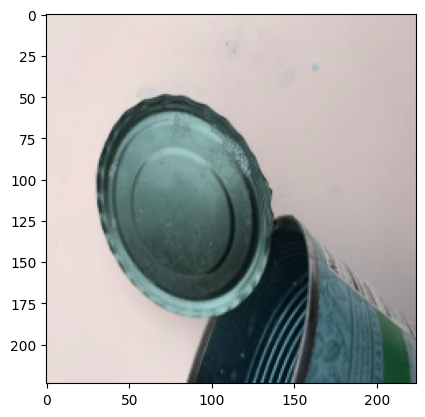

['metal']


In [ ]:
predict_image(model, '/content/garbage/metal/metal105.jpg')

## Using new image (not from dataset)
Please upload the image you want to predict

In [ ]:
image_path = files.upload()
for y in image_path.keys():
  path = y

Saving daqdw.webp to daqdw.webp


1/1 [==============================] - 0s 62ms/step


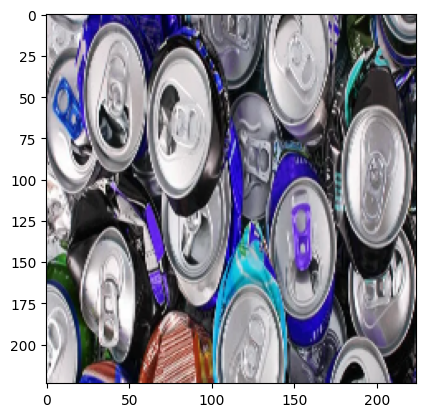

['metal']


In [ ]:
predict_image(model, path)

In [ ]:
image_path = files.upload()
for y in image_path.keys():
  path = y

Saving botol.jpg to botol.jpg


1/1 [==============================] - 0s 70ms/step


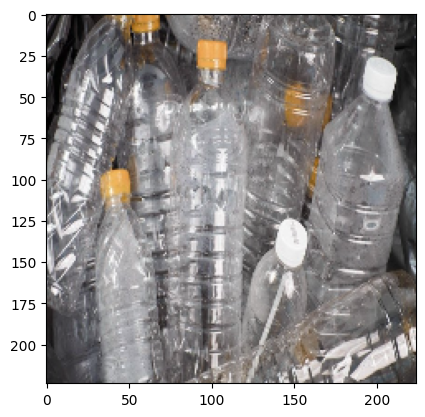

['plastic']


In [ ]:
predict_image(model, path)

In [ ]:
image_path = files.upload()
for y in image_path.keys():
  path = y

Saving download (3).jpeg to download (3).jpeg


1/1 [==============================] - 0s 64ms/step


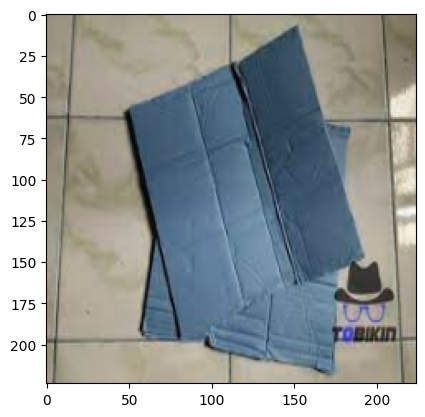

['cardboard']


In [ ]:
predict_image(model, path)

In [ ]:
image_path = files.upload()
for y in image_path.keys():
  path = y

Saving Newspaper.jpg to Newspaper.jpg


1/1 [==============================] - 0s 125ms/step


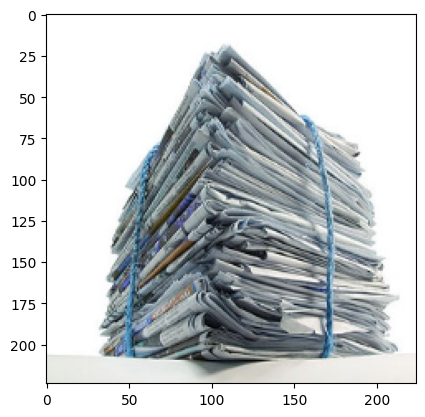

['paper']


In [ ]:
predict_image(model, path)

In [ ]:
image_path = files.upload()
for y in image_path.keys():
  path = y

Saving istockphoto-1445743631-612x612.jpg to istockphoto-1445743631-612x612.jpg


1/1 [==============================] - 0s 122ms/step


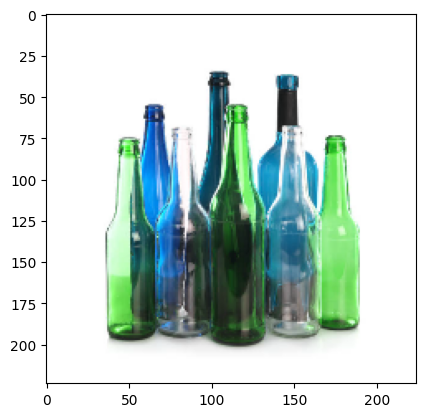

['glass']


In [ ]:
predict_image(model, path)